In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline


In [2]:
data = pd.read_excel('Zenith angle vs. coincident count rate.xlsx')

In [3]:
data

,Zenith angle,Avg. count per hour
0,0,11.4
1,9,11.5
2,19,10.1
3,28,8.8
4,34,8.3
5,40,7.7
6,45,5.8
7,53,5.6
8,66,3.1
9,70,3.0


In [4]:
X = data.iloc[:,0].values
y = data.iloc[:,1].values

<img src="https://latex.codecogs.com/gif.latex?\delta&space;Y&space;=&space;\sqrt{\frac{Y}{T}}" title="\delta Y = \sqrt{\frac{Y}{T}}" />

In [5]:
T = 48   # Number of hours data taken
Avg_error = np.sqrt(y/T)
data["Avg_Count_Error"] = np.round(Avg_error, decimals=2)
data

,Zenith angle,Avg. count per hour,Avg_Count_Error
0,0,11.4,0.49
1,9,11.5,0.49
2,19,10.1,0.46
3,28,8.8,0.43
4,34,8.3,0.42
5,40,7.7,0.40
6,45,5.8,0.35
7,53,5.6,0.34
8,66,3.1,0.25
9,70,3.0,0.25


In [6]:
from scipy import optimize

### func1 = aCos(x)^n+b

In [7]:
def func1(x, a, n, b):
    return a*np.cos(np.deg2rad(X))**n + b

In [8]:
popt_func1, pcov_func1 = optimize.curve_fit(func1, X, y, p0=[1, 0, 0])

In [9]:
param = ['a','n','b']

In [10]:
for i in range(3):
    print ('Value for',param[i],' = ',popt_func1[i])

Value for a  =  9.338158293628565
Value for n  =  2.196544842507936
Value for b  =  2.060499473893638


In [11]:
perr = np.sqrt(np.diag(pcov_func1))
for i in range(3):
    print ('standard deviation error for',param[i],' = ',perr[i])

standard deviation error for a  =  0.33827630183132446
standard deviation error for n  =  0.21471318840975576
standard deviation error for b  =  0.2858942016107567


### Fitted curve to func 1 - (Flat earth approx.)

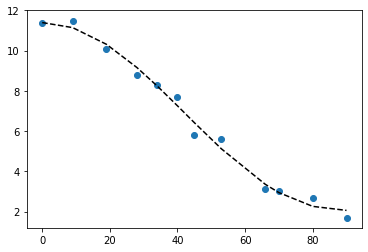

In [12]:
plt.scatter(X,y)
plt.plot(X,func1(X,*popt_func1),'k--')

In [13]:
from sklearn.metrics import r2_score
print('R^2 score :',r2_score(y,func1(X,*popt_func1)))

R^2 score : 0.9887736063413974


### func2 = a*Cos(X+k)^n + b

In [14]:
def func2(x, a, b, n, k):
    return a*np.cos(np.deg2rad(X+k))**n + b

In [15]:
popt_func2, pcov_func2 = optimize.curve_fit(func2, X, y, p0=[1, 0, 0, -5])

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


In [16]:
print('Value for k = ',popt_func2[-1])


Value for k =  -2.275585885558386e-06


### Ratio of pathlengths (S/d)

<img src="https://latex.codecogs.com/gif.latex?D(\theta)&space;=&space;\frac{S}{d}&space;=&space;\sqrt{\left&space;(&space;\frac{R^{2}}{d^{2}}cos^{2}(\theta)&space;&plus;&space;2\frac{R}{d}&space;&plus;&space;1&space;\right&space;)}&space;-&space;\frac{R}{d}cos(\theta)" title="D(\theta) = \frac{S}{d} = \sqrt{\left ( \frac{R^{2}}{d^{2}}cos^{2}(\theta) + 2\frac{R}{d} + 1 \right )} - \frac{R}{d}cos(\theta)" />

In [17]:
def D(theta,k):
    """ theta -> in degrees
        k = R/d 
    """
    return np.sqrt((k*np.cos(np.deg2rad(theta)))**2 + 2*k + 1) - k*np.cos(np.deg2rad(theta))

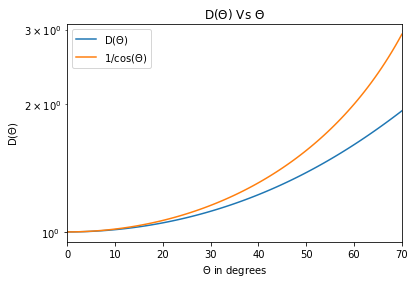

In [18]:
x = np.linspace(0,70,100)
F = D(x,4)
plt.plot(x,F, label=r'D($\Theta$)')
plt.yscale('log')
plt.xlabel(r'$\Theta$ in degrees')
plt.ylabel(r'D($\Theta$)')
plt.title(r'D($\Theta$) Vs $\Theta$')
f = 1/np.cos(np.deg2rad(x))
plt.plot(x,f, label=r'1/cos($\Theta$)')
plt.xlim([0,x[-1]])
plt.legend()

R2 Score is 0.85 at k = 9.090909090909092


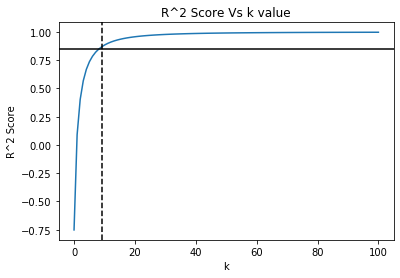

In [19]:
K = np.linspace(0,100,100)
R2_score = np.zeros(shape=K.shape)
for i,k in enumerate(K):
    F = D(x,k)
    f = 1/np.cos(np.deg2rad(x))
    R2_score[i] = r2_score(f,F)
plt.plot(K,R2_score)
plt.title('R^2 Score Vs k value')
plt.ylabel('R^2 Score')
plt.xlabel('k')
plt.axhline(y=0.85, ls='-', c='black')
min_R2 = np.where(R2_score>=0.85)[0][0] # Get minimum value for k s.t. R^2 score >=0.85
plt.axvline(x=K[min_R2], ls='--', c='black')

min_R2 = np.where(R2_score>=0.85)[0][0]
print('R2 Score is 0.85 at k = '+str(K[min_R2]))   # Value varies with maximum angle

### Distribution

<img src="https://latex.codecogs.com/gif.latex?\Phi&space;=&space;I_{0}D(\theta)^{-(n-1)}" title="\Phi = I_{0}D(\theta)^{-(n-1)}" />

In [20]:
def flux_n(theta,I0,n):
    k = param["k"][0]
    return I0*D(theta,k)**-(n-1)

In [21]:
def flux_k(theta,I0,k):
    n = param["n"][0]
    return I0*D(theta,k)**-(n-1)

In [22]:
n_0 = 3       #initial n value
R = 6371    #Earth's Radius

I0_shukla = 88.0   # I0 value from Shukla's work

In [23]:
# Make space for parameters and their errors
I0 = np.ones(shape=(2))
k = np.ones(shape=(2))
n = np.array([n_0 , 0.])
param = {"I0":I0, 
         "k":k, 
         "n":n}

Obtained value for area is 0.12642642642642643


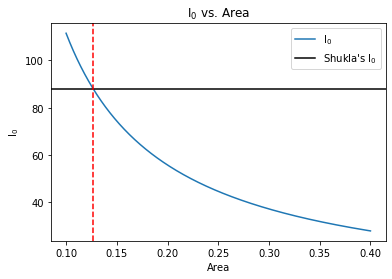

In [24]:
area = np.linspace(0.1, 0.4, 1000)
i0 = []
for a in area:
    popt_flux, pcov_flux = optimize.curve_fit(flux_k,X,y/a,p0=[10,4])
    I0 = popt_flux[0]
    i0.append(I0)

i0 = np.array(i0)    
# plt.figure(figsize=(9,7))

plt.xlabel('Area')
plt.ylabel(r'I$_0$')
plt.title(r'I$_0$ vs. Area')
plt.plot(area,i0,label='I$_0$')
plt.axhline(y=I0_shukla,c='black',label="Shukla's I$_0$")

index = np.where(i0>=I0_shukla)[0][-1]   # Get index of corresponding I0 value
area = area[index]   # save effective area

plt.axvline(x=area,ls='--',c='r')
plt.legend()
print('Obtained value for area is ' + str(area))

In [25]:
Y_new = y/area    # To obtain flux formv the count

In [26]:
popt_flux, pcov_flux = optimize.curve_fit(flux_k,X,Y_new,p0=[10,4])   # Optimizing values for I0 and k
#Updating parameters
param["I0"] = [popt_flux[0], perr[0]]
param["k"] = [popt_flux[1], perr[1]]

perr = np.sqrt(np.diag(pcov_flux))         #Getting std errors

print(param)

I0 = param['I0'][0]
k = param['k'][0]
n = param['n'][0]

{'I0': [88.20050782629559, 0.33827630183132446], 'k': [3.795421001285907, 0.21471318840975576], 'n': array([3., 0.])}


### Goodness of fit

In [27]:
from scipy import stats
d = I0*D(X,k)**(1-n)
pvalue = stats.chisquare(f_obs= Y_new, f_exp = d)[1]
print(stats.chisquare(f_obs= Y_new, f_exp = d))

Power_divergenceResult(statistic=4.704917846008202, pvalue=0.944610911396897)


### 1-sigma & 2-sigma contour

<img src="https://latex.codecogs.com/gif.latex?p&space;=&space;erf\left&space;(&space;\frac{\sigma&space;}{\sqrt{2}}&space;\right&space;)" title="p = erf\left ( \frac{\sigma }{\sqrt{2}} \right )" />

In [42]:
from scipy import special
sigma = lambda p : np.sqrt(2)*special.erfinv(p)   # Calculate sigma for a given p value
p_val = lambda sigma : special.erf(sigma/np.sqrt(2))   # Calculate p value for a given sigma
Sigma = sigma(pvalue)   # Current Sigma 
print ('Sigma = '+str(Sigma))
Sigma_1 = Sigma-1   # Reduced 1 sigma for genetrate contour
P_1 = p_val(Sigma_1)   # Corresponding p value for reduced sigma

Sigma = 1.9158115378282627


In [43]:
h = 300   # Number of intervals
buffer1=[]
buffer2=[]
I0_Test = I0 + np.linspace(-50,50,h)
k_Test = k + np.linspace(-3,8,h)
for k_test in k_Test:
    for I0_test in I0_Test:
        y_test = I0_test*D(X,k_test)**(1-n)
        C = (stats.chisquare(f_obs= y_test, f_exp = d)[0])   # Get chi2 value for corresponding co-ordinates
        P = (stats.chisquare(f_obs= y_test, f_exp = d)[1])   # Get p value for corresponding co-ordinates
        if P >= P_1:
            buffer1.append([I0_test, k_test])   # 1-sigma contour
        elif C <=11:
            buffer2.append([I0_test, k_test])   # 2-sigma contour
buffer1 = np.array(buffer1)
buffer2 = np.array(buffer2)

Text(0, 0.5, 'k')

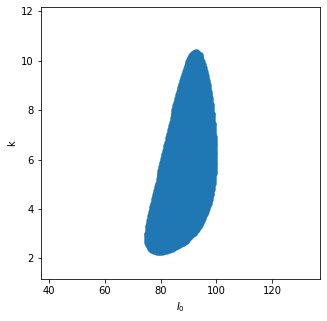

In [44]:
plt.figure(figsize=(5,5))

plt.plot(buffer1[:,0],buffer1[:,1],'.')
# plt.plot(buffer2[:,0],buffer2[:,1],'r.')
plt.xlim(I0_Test[0],I0_Test[-1])
plt.ylim(k_Test[0],k_Test[-1])

plt.xlabel('$I_0$')
plt.ylabel('k')

### Calculating bias 

Chi2 is minimized(4.20220383712217) at b = 1.1811811811811812


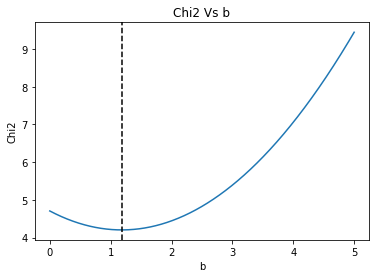

In [31]:
d_theory = I0*(D(X,174)**-(n-1))   # Theoretical distribution
d = I0*(D(X,k)**-(n-1))   # Obtained distribution

b = np.linspace(0,5,1000)   # Error:- (5-0)/1000 
Chi2 = np.zeros(shape=b.shape)
for i in range(b.shape[0]):
    Y_obs = Y_new - b[i]
    Chi2[i] = stats.chisquare(f_obs= Y_obs, f_exp = d)[0]

    
plt.plot(b,Chi2)
plt.axvline(x=b[np.where(Chi2==Chi2.min())[0][0]], ls='--', c='black')
plt.title('Chi2 Vs b')
plt.xlabel('b')
plt.ylabel('Chi2')
print('Chi2 is minimized('+str(Chi2.min())+') at b = '+str(b[np.where(Chi2==Chi2.min())[0][0]]))

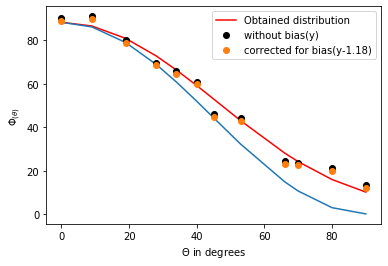

In [32]:
bias = b[np.where(Chi2==Chi2.min())[0][0]]
Y_New = Y_new-bias       # Flux - Corrected for bias
plt.plot(X,d,'r', label='Obtained distribution')
plt.plot(X,d_theory)
plt.plot(X,Y_new,'ko', label='without bias(y)')
plt.plot(X,Y_New,'o',label='corrected for bias(y-%.2f)' % bias) 
plt.xlabel(r'$\Theta$ in degrees')
plt.ylabel(r'$\Phi_{(\theta)}$')
           
plt.legend()

### Error in Y_New

<img src="https://latex.codecogs.com/gif.latex?\delta&space;Y_{New}&space;=&space;\sqrt{\left&space;(&space;\frac{\delta&space;Y}{area}&space;\right&space;)^2&space;&plus;&space;\left&space;(&space;\delta&space;b&space;\right&space;)^2}" title="\delta Y_{New} = \sqrt{\left ( \frac{\delta Y}{area} \right )^2 + \left ( \delta b \right )^2}" />

Text(0, 0.5, '$\\Phi_{(\\theta)}$')

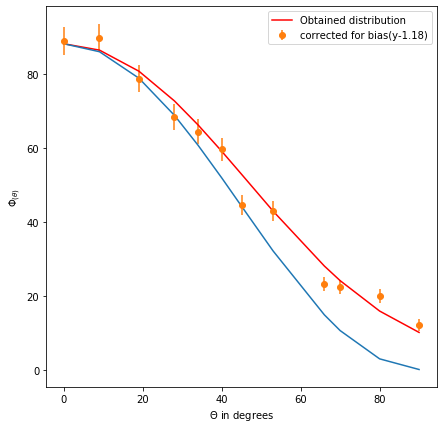

In [33]:
Y_New_error = np.sqrt((data.iloc[:,2].values/area)**2 + (5/1000)**2)

bias = b[np.where(Chi2==Chi2.min())[0][0]]
Y_New = Y_new-bias       # Flux - Corrected for bias

plt.figure(figsize=(7,7))
plt.plot(X,d,'r', label='Obtained distribution')
plt.plot(X,d_theory)
# plt.plot(X,Y_new,'ko', label='without bias(y)')
plt.errorbar(X,Y_New,yerr=Y_New_error,marker='o',ls='',label='corrected for bias(y-%.2f)' % bias) 
plt.legend()
plt.xlabel(r'$\Theta$ in degrees')
plt.ylabel(r'$\Phi_{(\theta)}$')

In [34]:
print(stats.chisquare(f_obs= Y_New, f_exp = d_theory))
print(stats.chisquare(f_obs= Y_new, f_exp = d))
print(stats.chisquare(f_obs= Y_New, f_exp = d))


Power_divergenceResult(statistic=686.5907137450782, pvalue=4.0372283885398585e-140)
Power_divergenceResult(statistic=4.704917846008202, pvalue=0.944610911396897)
Power_divergenceResult(statistic=4.20220383712217, pvalue=0.9636242347445427)


### DATA table with background rate

In [35]:
background = (bias/I0)

In [36]:
background = np.ones(shape=X.shape)*background
data["Background Rate"] = np.round(background, decimals=2)

In [37]:
data

,Zenith angle,Avg. count per hour,Avg_Count_Error,Background Rate
0,0,11.4,0.49,0.01
1,9,11.5,0.49,0.01
2,19,10.1,0.46,0.01
3,28,8.8,0.43,0.01
4,34,8.3,0.42,0.01
5,40,7.7,0.40,0.01
6,45,5.8,0.35,0.01
7,53,5.6,0.34,0.01
8,66,3.1,0.25,0.01
9,70,3.0,0.25,0.01


In [38]:
popt_flux, pcov_flux = optimize.curve_fit(flux_k,X,Y_New,p0=[10,4])   # Optimizing values for I0 and k
#Updating parameters
param["I0"] = [popt_flux[0], perr[0]]
param["k"] = [popt_flux[1], perr[1]]

perr = np.sqrt(np.diag(pcov_flux))         #Getting std errors

print(param)

I0 = param['I0'][0]
k = param['k'][0]
n = param['n'][0]

{'I0': [87.10622919709876, 1.9104572262419917], 'k': [4.167841570323244, 0.6908439322515592], 'n': array([3., 0.])}


In [39]:
d = I0*(D(X,k)**-(n-1))   # Obtained distribution

In [40]:
print(stats.chisquare(f_obs= Y_New, f_exp = d))

Power_divergenceResult(statistic=4.73267012535045, pvalue=0.9434187269551695)
